In [1]:
# Import dependencies
import psycopg2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Set up connection to database
engine = psycopg2.connect(
    database="stroke_dataset",
    user = "postgres",
    password = "bootcamp",
    host = "final-project.cpi4gz0jwsu4.us-west-1.rds.amazonaws.com",
    port = '5432'
    )

cursor = engine.cursor()

In [3]:
# Pull in working dataset from database
sql = """
SELECT "FIPS", "Num_Per_100k", "State", "County", "Percent_Smokers", "Percent_Obese", "Food_Environment_Index", "Percent_Access_Exercise", "Primary_Care_Physician_Rate", "Mental_Health_Providers_Rate", "Percent_Some_College", "Percent_Unemployed", "Income_Inequality_Ratio", "Violent_Crime_Rate", "Average_Daily_Air_Polution_Particle_Matter", "Percent_Long_Commute_Drives_Alone", "Percent_Rural"
FROM public."All_Data"
"""

all_data_df = pd.read_sql(sql, con=engine)
all_data_df.head()

,FIPS,Num_Per_100k,State,County,Percent_Smokers,Percent_Obese,Food_Environment_Index,Percent_Access_Exercise,Primary_Care_Physician_Rate,Mental_Health_Providers_Rate,Percent_Some_College,Percent_Unemployed,Income_Inequality_Ratio,Violent_Crime_Rate,Average_Daily_Air_Polution_Particle_Matter,Percent_Long_Commute_Drives_Alone,Percent_Rural
0,1001.0,107.0,Alabama,Autauga,19.0,36.0,7.1,71.0,45.0,13.0,61.9,5.3,4.4,266.0,10.8,41.0,42.0
1,1003.0,82.5,Alabama,Baldwin,17.0,29.0,7.9,69.0,73.0,89.0,63.8,5.4,4.6,217.0,9.6,40.0,42.3
2,1005.0,96.1,Alabama,Barbour,22.0,44.0,5.5,53.0,42.0,8.0,39.7,8.6,5.9,329.0,10.1,35.0,67.8
3,1007.0,112.3,Alabama,Bibb,20.0,38.0,7.6,49.0,53.0,9.0,49.8,6.6,4.2,147.0,10.5,49.0,68.4
4,1009.0,96.1,Alabama,Blount,20.0,36.0,8.5,32.0,21.0,9.0,53.9,5.5,4.1,212.0,11.3,60.0,90.0


In [5]:
# Check for null values
all_data_df.isnull().sum()

FIPS                                            0
Num_Per_100k                                    7
State                                           0
County                                          0
Percent_Smokers                                 0
Percent_Obese                                   0
Food_Environment_Index                         19
Percent_Access_Exercise                         6
Primary_Care_Physician_Rate                   134
Mental_Health_Providers_Rate                  264
Percent_Some_College                            0
Percent_Unemployed                              1
Income_Inequality_Ratio                         2
Violent_Crime_Rate                            176
Average_Daily_Air_Polution_Particle_Matter     34
Percent_Long_Commute_Drives_Alone               0
Percent_Rural                                   7
dtype: int64

In [6]:
# Drop null values
all_data_df = all_data_df.dropna(axis=0)

In [7]:
# Drop identifier columns
all_data_usable_df = all_data_df.drop(["FIPS", "State", "County"], 1)
all_data_usable_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,Num_Per_100k,Percent_Smokers,Percent_Obese,Food_Environment_Index,Percent_Access_Exercise,Primary_Care_Physician_Rate,Mental_Health_Providers_Rate,Percent_Some_College,Percent_Unemployed,Income_Inequality_Ratio,Violent_Crime_Rate,Average_Daily_Air_Polution_Particle_Matter,Percent_Long_Commute_Drives_Alone,Percent_Rural
0,107.0,19.0,36.0,7.1,71.0,45.0,13.0,61.9,5.3,4.4,266.0,10.8,41.0,42.0
1,82.5,17.0,29.0,7.9,69.0,73.0,89.0,63.8,5.4,4.6,217.0,9.6,40.0,42.3
2,96.1,22.0,44.0,5.5,53.0,42.0,8.0,39.7,8.6,5.9,329.0,10.1,35.0,67.8
3,112.3,20.0,38.0,7.6,49.0,53.0,9.0,49.8,6.6,4.2,147.0,10.5,49.0,68.4
4,96.1,20.0,36.0,8.5,32.0,21.0,9.0,53.9,5.5,4.1,212.0,11.3,60.0,90.0


Random Forest Regressor - all features

In [8]:
# https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/
# Divide data into attributes and labels

X = all_data_usable_df.drop(["Num_Per_100k"], 1)
y = pd.DataFrame(all_data_usable_df["Num_Per_100k"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [9]:
# Divide data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:
# Train random forest algorithm to solve this regression problem
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Mean Absolute Error: 9.59015122873346
Mean Squared Error: 152.45820132325142
Root Mean Squared Error: 12.34739654029348


In [12]:
# Increase estimators to 50
regressor = RandomForestRegressor(n_estimators=50, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Mean Absolute Error: 9.381482041587901
Mean Squared Error: 147.05343147069945
Root Mean Squared Error: 12.12655892950261


In [13]:
# Calculate feature importance in the Random Forest model.
importances = regressor.feature_importances_
importances

array([0.21028464, 0.07067463, 0.10132374, 0.04427675, 0.04706694,
       0.05832781, 0.05115491, 0.07532454, 0.07067817, 0.06882491,
       0.10358296, 0.0525527 , 0.04592729])

In [14]:
# List the features in order of importance
importances_df = pd.DataFrame(X.columns, columns=["Feature"])
importances_df["Importance"] = importances
importances_df.sort_values('Importance', ascending=False, inplace=True)
importances_df

,Feature,Importance
0,Percent_Smokers,0.210285
10,Average_Daily_Air_Polution_Particle_Matter,0.103583
2,Food_Environment_Index,0.101324
7,Percent_Unemployed,0.075325
8,Income_Inequality_Ratio,0.070678
1,Percent_Obese,0.070675
9,Violent_Crime_Rate,0.068825
5,Mental_Health_Providers_Rate,0.058328
11,Percent_Long_Commute_Drives_Alone,0.052553
6,Percent_Some_College,0.051155


Text(0.5, 1.0, 'Plot Feature Importances')

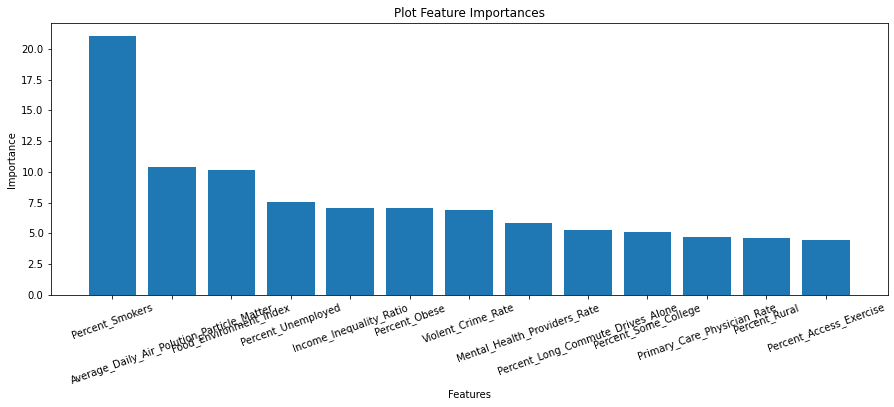

In [15]:
# Plot the features in order of importance
plt.figure(figsize=(15,5))
ax = importances_df['Feature']
plt.bar(range(importances_df.shape[0]), importances_df['Importance']*100)
plt.xticks(range(importances_df.shape[0]), importances_df['Feature'], rotation = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Plot Feature Importances")

In [16]:
# Change estimators to 30
regressor = RandomForestRegressor(n_estimators=30, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Mean Absolute Error: 9.529855072463768
Mean Squared Error: 151.97988124343624
Root Mean Squared Error: 12.328012055616925


Random Forest Regressor - Top 5 Importance

In [17]:
# Narrow the data down to the top 5 most important features 
X = all_data_usable_df.drop(["Num_Per_100k","Percent_Obese","Percent_Access_Exercise","Primary_Care_Physician_Rate","Mental_Health_Providers_Rate","Percent_Some_College","Violent_Crime_Rate","Percent_Long_Commute_Drives_Alone","Percent_Rural"], 1)
y = pd.DataFrame(all_data_usable_df["Num_Per_100k"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [18]:
# Check data types
X.dtypes

Percent_Smokers                               float64
Food_Environment_Index                        float64
Percent_Unemployed                            float64
Income_Inequality_Ratio                       float64
Average_Daily_Air_Polution_Particle_Matter    float64
dtype: object

In [19]:
# Check for null values
X.isnull().sum()

Percent_Smokers                               0
Food_Environment_Index                        0
Percent_Unemployed                            0
Income_Inequality_Ratio                       0
Average_Daily_Air_Polution_Particle_Matter    0
dtype: int64

In [20]:
# Divide data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
# Train random forest algorithm to solve this regression problem
regressor = RandomForestRegressor(n_estimators=30, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Find the Root Mean Squared Error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Mean Absolute Error: 9.844814114681789
Mean Squared Error: 164.05482075194288
Root Mean Squared Error: 12.808388686792062


In [23]:
# Increase estimators to 50
regressor = RandomForestRegressor(n_estimators=50, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Mean Absolute Error: 9.74439697542533
Mean Squared Error: 159.15277181852548
Root Mean Squared Error: 12.615576555137125


In [24]:
# Calculate feature importance in the Random Forest model.
importances = regressor.feature_importances_
importances

array([0.26311855, 0.19618657, 0.18260749, 0.14879291, 0.20929447])

In [25]:
# List the features in order of importance
importances_df = pd.DataFrame(X.columns, columns=["Feature"])
importances_df["Importance"] = importances
importances_df.sort_values('Importance', ascending=False, inplace=True)
importances_df

,Feature,Importance
0,Percent_Smokers,0.263119
4,Average_Daily_Air_Polution_Particle_Matter,0.209294
1,Food_Environment_Index,0.196187
2,Percent_Unemployed,0.182607
3,Income_Inequality_Ratio,0.148793


Text(0.5, 1.0, 'Plot Feature Importances')

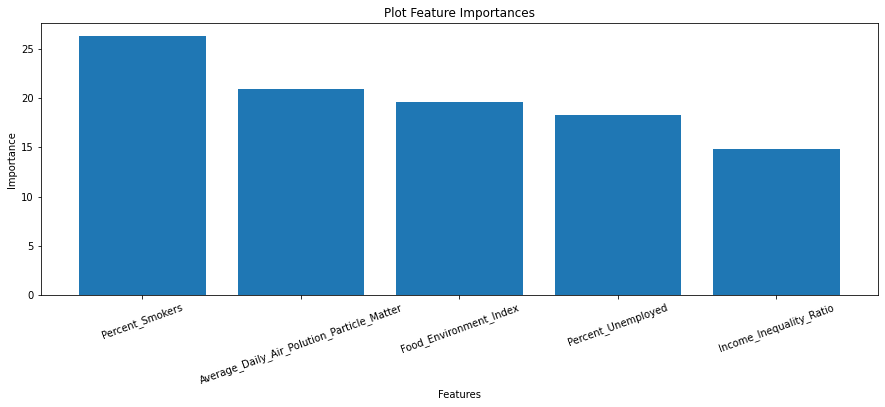

In [26]:
# Plot the features in order of importance
plt.figure(figsize=(15,5))
ax = importances_df['Feature']
plt.bar(range(importances_df.shape[0]), importances_df['Importance']*100)
plt.xticks(range(importances_df.shape[0]), importances_df['Feature'], rotation = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Plot Feature Importances")

In [27]:
# Output the model via Pickle to a file
pickle_out = open("model.pkl", "wb")
pickle.dump(regressor, pickle_out)
pickle_out.close()

In [28]:
# Change estimators to 30
regressor = RandomForestRegressor(n_estimators=30, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Mean Absolute Error: 9.844814114681789
Mean Squared Error: 164.05482075194288
Root Mean Squared Error: 12.808388686792062


Random Forest Regressor - health features

In [29]:
# Drop non-health feature columns
health_features_df = all_data_usable_df.drop(["Percent_Rural", "Percent_Long_Commute_Drives_Alone", "Average_Daily_Air_Polution_Particle_Matter", "Violent_Crime_Rate", "Income_Inequality_Ratio", "Percent_Unemployed", "Percent_Some_College"], 1)
health_features_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,Num_Per_100k,Percent_Smokers,Percent_Obese,Food_Environment_Index,Percent_Access_Exercise,Primary_Care_Physician_Rate,Mental_Health_Providers_Rate
0,107.0,19.0,36.0,7.1,71.0,45.0,13.0
1,82.5,17.0,29.0,7.9,69.0,73.0,89.0
2,96.1,22.0,44.0,5.5,53.0,42.0,8.0
3,112.3,20.0,38.0,7.6,49.0,53.0,9.0
4,96.1,20.0,36.0,8.5,32.0,21.0,9.0


In [30]:
# Divide into attributes and labels
X = all_data_usable_df.iloc[:, 1:7].values
y = all_data_usable_df.iloc[:, 0].values

In [31]:
# Divide data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [32]:
# Scale Features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [33]:
# Train random forest algorithm to solve this regression problem
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 10.390255198487711
Mean Squared Error: 178.18698993383742
Root Mean Squared Error: 13.348669968721133


In [34]:
# Increase estimators to 50
regressor = RandomForestRegressor(n_estimators=50, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 10.262215500945178
Mean Squared Error: 172.17535106238185
Root Mean Squared Error: 13.121560542190927


In [35]:
# Change estimators to 30
regressor = RandomForestRegressor(n_estimators=30, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 10.255551354757404
Mean Squared Error: 173.63839512707418
Root Mean Squared Error: 13.177192232303291


Random Forest Regressor - environment / economic features

In [36]:
ee_features_df = all_data_usable_df.drop(["Percent_Smokers", "Percent_Obese", "Food_Environment_Index", "Percent_Access_Exercise", "Primary_Care_Physician_Rate", "Mental_Health_Providers_Rate"], 1)
ee_features_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,Num_Per_100k,Percent_Some_College,Percent_Unemployed,Income_Inequality_Ratio,Violent_Crime_Rate,Average_Daily_Air_Polution_Particle_Matter,Percent_Long_Commute_Drives_Alone,Percent_Rural
0,107.0,61.9,5.3,4.4,266.0,10.8,41.0,42.0
1,82.5,63.8,5.4,4.6,217.0,9.6,40.0,42.3
2,96.1,39.7,8.6,5.9,329.0,10.1,35.0,67.8
3,112.3,49.8,6.6,4.2,147.0,10.5,49.0,68.4
4,96.1,53.9,5.5,4.1,212.0,11.3,60.0,90.0


In [37]:
# Divide into attributes and labels
X = all_data_usable_df.iloc[:, 1:6].values
y = all_data_usable_df.iloc[:, 0].values

In [38]:
# Divide data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [39]:
# Scale Features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [40]:
# Train random forest algorithm to solve this regression problem
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 10.528317580340264
Mean Squared Error: 182.19479536862002
Root Mean Squared Error: 13.49795522916786


In [42]:
# Increase estimators to 50
regressor = RandomForestRegressor(n_estimators=50, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 10.329909262759925
Mean Squared Error: 174.4235131115312
Root Mean Squared Error: 13.20694942488731


In [43]:
# Change estimators to 30
regressor = RandomForestRegressor(n_estimators=30, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 10.43471329552615
Mean Squared Error: 178.69157187565636
Root Mean Squared Error: 13.367556690572005
